# Build Datasets: ML & CV Orchestrator

Run from the **project root**. It now do not uses `scripts/` modules to generate, all logic is here:
- ML features and labels parquet datasets
- Optional CV image renders for visual QA

Edit parameters in the next cell and execute top-to-bottom.


In [9]:
import pandas as pd
from datetime import datetime, timedelta, timezone
from tinkoff.invest import Client, CandleInterval
import pytz
from dotenv import load_dotenv
import os

# Загружаем переменные из .env
load_dotenv()

# ========= ПАРАМЕТРЫ ==========
TOKEN   = os.getenv("TINKOFF_TOKEN")      # токен из https://tinkoff.ru/invest/settings/
TICKER  = "SBER"
TF      = "5m"                   # варианты: 1m, 5m, 15m, 1h, 1d
START   = "2025-06-01"
END     = "2025-10-01"
# ==============================


def get_interval(tf: str):
    """Конвертер таймфреймов."""
    mapping = {
        "1m": CandleInterval.CANDLE_INTERVAL_1_MIN,
        "5m": CandleInterval.CANDLE_INTERVAL_5_MIN,
        "15m": CandleInterval.CANDLE_INTERVAL_15_MIN,
        "1h": CandleInterval.CANDLE_INTERVAL_HOUR,
        "1d": CandleInterval.CANDLE_INTERVAL_DAY,
    }
    return mapping.get(tf, CandleInterval.CANDLE_INTERVAL_1_MIN)


def fetch_candles_tinkoff(token: str, ticker: str, start: str, end: str, tf: str = "1m") -> pd.DataFrame:
    """Загружает свечи Tinkoff API в pandas.DataFrame"""
    with Client(token) as client:
        # Находим FIGI по тикеру
        figi = None
        instruments = client.instruments.shares().instruments
        for inst in instruments:
            if inst.ticker == ticker:
                figi = inst.figi
                break
        if not figi:
            raise ValueError(f"FIGI for {ticker} not found!")

        # интервалы времени (UTC!)
        tz = pytz.timezone("Europe/Moscow")
        from_dt = tz.localize(datetime.strptime(start, "%Y-%m-%d")).astimezone(timezone.utc)
        till_dt = tz.localize(datetime.strptime(end, "%Y-%m-%d") + timedelta(days=1)).astimezone(timezone.utc)

        interval = get_interval(tf)

        # Получаем свечи
        candles = client.get_all_candles(
            figi=figi,
            from_=from_dt,
            to=till_dt,
            interval=interval,
        )

        # Парсим в DataFrame
        rows = []
        for c in candles:
            rows.append({
                "time": c.time.astimezone(tz),
                "open": c.open.units + c.open.nano / 1e9,
                "high": c.high.units + c.high.nano / 1e9,
                "low":  c.low.units  + c.low.nano  / 1e9,
                "close":c.close.units+ c.close.nano/ 1e9,
                "volume": c.volume,
            })

        df = pd.DataFrame(rows)
        return df.sort_values("time").reset_index(drop=True)


# ============= запуск =============
if __name__ == "__main__":
    df = fetch_candles_tinkoff(TOKEN, TICKER, START, END, TF)
    print(f"Получено {len(df)} свечей {TF} для {TICKER}")
    print(df.head())

    # Сохранить в CSV при желании
    df.to_csv(f"{TICKER}_{START}_{TF}.csv", index=False)


Получено 26563 свечей 5m для SBER
                       time    open    high     low   close  volume
0 2025-06-01 02:00:00+03:00  308.50  309.20  308.50  308.51    1280
1 2025-06-01 02:05:00+03:00  308.00  308.99  308.00  308.79     200
2 2025-06-01 02:20:00+03:00  308.69  308.70  308.34  308.34      50
3 2025-06-01 02:25:00+03:00  308.34  308.70  308.34  308.70      40
4 2025-06-01 02:30:00+03:00  308.36  308.69  308.36  308.69      30


In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import pytz
from tinkoff.invest import Client, CandleInterval

# ===================== НАСТРОЙКИ =====================
TOKEN   = os.getenv("TINKOFF_TOKEN")           # 🔐 токен API (https://tinkoff.ru/invest/settings/)
TICKER  = "SBER"                      # тикер бумаги
START   = "2025-06-01"
END     = "2025-10-01"
TF      = "5m"                        # '1m', '5m', '15m', '1h', '1d'
TP_MULT = 1.5                         # множитель ATR для take-profit
SL_MULT = 1.5                         # множитель ATR для stop-loss
ATR_PERIOD = 14                       # период ATR
# ====================================================


# ---------- УТИЛИТЫ ----------
def get_interval(tf: str):
    return {
        "1m": CandleInterval.CANDLE_INTERVAL_1_MIN,
        "5m": CandleInterval.CANDLE_INTERVAL_5_MIN,
        "15m": CandleInterval.CANDLE_INTERVAL_15_MIN,
        "1h": CandleInterval.CANDLE_INTERVAL_HOUR,
        "1d": CandleInterval.CANDLE_INTERVAL_DAY,
    }.get(tf, CandleInterval.CANDLE_INTERVAL_5_MIN)


def fetch_candles_tinkoff(token: str, ticker: str, start: str, end: str, tf: str) -> pd.DataFrame:
    """Грузим свечи по FIGI через Tinkoff API."""
    with Client(token) as client:
        # FIGI
        figi = next((inst.figi for inst in client.instruments.shares().instruments if inst.ticker == ticker), None)
        if not figi:
            raise ValueError(f"FIGI для {ticker} не найден")

        tz = pytz.timezone("Europe/Moscow")
        from_dt = tz.localize(datetime.strptime(start, "%Y-%m-%d")).astimezone(timezone.utc)
        till_dt = tz.localize(datetime.strptime(end, "%Y-%m-%d") + timedelta(days=1)).astimezone(timezone.utc)

        candles = client.get_all_candles(figi=figi, from_=from_dt, to=till_dt, interval=get_interval(tf))
        rows = [{
            "time": c.time.astimezone(tz),
            "open": c.open.units + c.open.nano / 1e9,
            "high": c.high.units + c.high.nano / 1e9,
            "low":  c.low.units  + c.low.nano  / 1e9,
            "close":c.close.units+ c.close.nano/ 1e9,
            "volume": c.volume
        } for c in candles]
        return pd.DataFrame(rows).sort_values("time").reset_index(drop=True)


# ---------- ФИЧИ: технические индикаторы ----------
def add_technical_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # скользящие средние
    df["sma_5"]  = df["close"].rolling(5).mean()
    df["sma_10"] = df["close"].rolling(10).mean()
    df["ema_10"] = df["close"].ewm(span=10).mean()
    df["ema_20"] = df["close"].ewm(span=20).mean()
    df["sma_ratio"] = df["sma_5"] / df["sma_10"] - 1

    # RSI
    delta = df["close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df["rsi"] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df["boll_mid"] = df["close"].rolling(20).mean()
    df["boll_std"] = df["close"].rolling(20).std()
    df["boll_up"]  = df["boll_mid"] + 2 * df["boll_std"]
    df["boll_low"] = df["boll_mid"] - 2 * df["boll_std"]
    df["boll_pos"] = (df["close"] - df["boll_low"]) / (df["boll_up"] - df["boll_low"])

    # Momentum
    df["momentum_5"] = df["close"] - df["close"].shift(5)
    df["momentum_10"] = df["close"] - df["close"].shift(10)

    # Log-returns
    df["log_ret"] = np.log(df["close"] / df["close"].shift(1))

    # ATR для последующей разметки
    df["tr"] = df[["high", "low", "close"]].apply(
        lambda x: max(x["high"] - x["low"],
                      abs(x["high"] - df["close"].shift(1).iloc[x.name]),
                      abs(x["low"]  - df["close"].shift(1).iloc[x.name])), axis=1)
    df["atr"] = df["tr"].rolling(ATR_PERIOD).mean()

    return df.dropna().reset_index(drop=True)


# ---------- Triple Barrier Method ----------
def make_labels_atr(df: pd.DataFrame, atr_period=14, tp_mult=1.5, sl_mult=1.5):
    df = df.copy()
    df["label"] = "flat"
    n = len(df)

    for i in range(n - atr_period - 1):
        entry_price = df.loc[i, "close"]
        atr = df.loc[i, "atr"]
        tp = entry_price * (1 + tp_mult * atr / entry_price)
        sl = entry_price * (1 - sl_mult * atr / entry_price)
        window = df.loc[i + 1 : i + atr_period]

        if (window["high"] >= tp).any():
            df.loc[i, "label"] = "up"
        elif (window["low"] <= sl).any():
            df.loc[i, "label"] = "down"
        else:
            df.loc[i, "label"] = "flat"

    df = df.dropna(subset=["label"])
    return df


# ---------- PIPELINE ----------
def build_dataset_tinkoff():
    print("📥 Загружаем данные...")
    df_raw = fetch_candles_tinkoff(TOKEN, TICKER, START, END, TF)
    print(f"Получено {len(df_raw)} свечей")

    print("⚙️ Генерируем технические фичи...")
    df_feat = add_technical_features(df_raw)

    print("🏷️ Размечаем лейблы по Triple-Barrier...")
    df_final = make_labels_atr(df_feat, atr_period=ATR_PERIOD,
                               tp_mult=TP_MULT, sl_mult=SL_MULT)

    # удалим ненужные столбцы
    drop_cols = ["tr"]
    df_final = df_final.drop(columns=[c for c in drop_cols if c in df_final.columns])

    print("✅ Датасет готов:", df_final.shape)
    return df_final


if __name__ == "__main__":
    dataset = build_dataset_tinkoff()
    print(dataset.head(10))
    dataset.to_csv(f"{TICKER}_dataset_{TF}.csv", index=False)
    print(f"💾 Сохранено: {TICKER}_dataset_{TF}.csv")


📥 Загружаем данные...
Получено 26563 свечей
⚙️ Генерируем технические фичи...
🏷️ Размечаем лейблы по Triple-Barrier...
✅ Датасет готов: (26543, 22)
                       time    open    high     low   close  volume    sma_5  \
0 2025-06-01 04:15:00+03:00  308.58  308.58  308.58  308.58      10  308.584   
1 2025-06-01 04:20:00+03:00  308.50  308.50  308.40  308.40      20  308.544   
2 2025-06-01 04:25:00+03:00  308.60  308.60  308.60  308.60      10  308.548   
3 2025-06-01 04:30:00+03:00  308.35  308.35  308.35  308.35      50  308.502   
4 2025-06-01 04:45:00+03:00  308.60  308.60  308.60  308.60      70  308.506   
5 2025-06-01 04:55:00+03:00  308.35  308.35  308.35  308.35      10  308.460   
6 2025-06-01 05:00:00+03:00  308.60  308.60  308.60  308.60      10  308.500   
7 2025-06-01 05:15:00+03:00  308.35  308.59  307.92  308.59    6850  308.498   
8 2025-06-01 05:20:00+03:00  308.59  308.79  308.03  308.59    2260  308.546   
9 2025-06-01 05:25:00+03:00  308.59  308.79  308.59 

In [10]:
d = pd.read_csv('data/SBER_dataset_5m.csv')
d.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'sma_5', 'sma_10',
       'ema_10', 'ema_20', 'sma_ratio', 'rsi', 'boll_mid', 'boll_std',
       'boll_up', 'boll_low', 'boll_pos', 'momentum_5', 'momentum_10',
       'log_ret', 'atr', 'label'],
      dtype='object')

📊 Проверка баланса классов:
       count  percent
label                
up     11778    44.37
down    8659    32.62
flat    6106    23.00


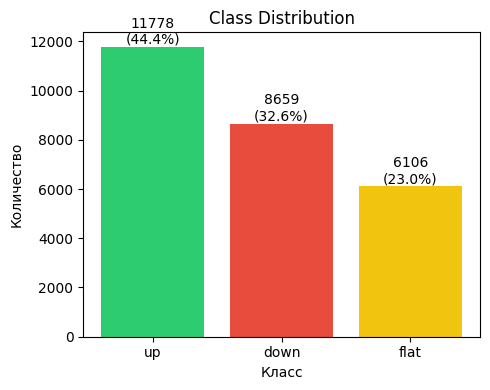

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Если у тебя уже есть dataset из build_dataset_tinkoff():
# dataset = build_dataset_tinkoff()
# или загрузим из файла:
# dataset = pd.read_csv("SBER_dataset_5m.csv")

def check_class_balance(df: pd.DataFrame, label_col: str = "label", plot: bool = True):
    """Проверка баланса классов по лейблам (up/down/flat)."""
    print("📊 Проверка баланса классов:")
    counts = df[label_col].value_counts()
    percents = df[label_col].value_counts(normalize=True) * 100
    balance_df = pd.DataFrame({"count": counts, "percent": percents.round(2)})
    print(balance_df)

    if plot:
        plt.figure(figsize=(5, 4))
        plt.bar(balance_df.index, balance_df["count"], color=["#2ecc71", "#e74c3c", "#f1c40f"])
        plt.title("Class Distribution")
        plt.ylabel("Количество")
        plt.xlabel("Класс")
        for i, v in enumerate(balance_df["count"]):
            plt.text(i, v, f"{v}\n({balance_df['percent'].iloc[i]:.1f}%)",
                     ha="center", va="bottom", fontsize=10)
        plt.tight_layout()
        plt.show()
    return balance_df


# Пример запуска:
if __name__ == "__main__":
    dataset = pd.read_csv("data/SBER_dataset_5m.csv")
    balance = check_class_balance(dataset)


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# ===== ПАРАМЕТРЫ =====
LOOKBACK = 60
OUT_DIR = "cv_candles_seq"
IMG_SIZE = (8, 4)
DPI = 100
USE_JPG = True
# ======================

# === КАСТОМНЫЙ СТИЛЬ ===
my_style = mpf.make_mpf_style(
    base_mpf_style='nightclouds',
    facecolor='black',
    edgecolor='white',
    marketcolors=mpf.make_marketcolors(
        up='lime', down='red', edge='white', wick='white', volume='gray'
    ),
    rc={'axes.labelcolor': 'white', 'axes.edgecolor': 'white'}
)


def render_one(index, df, img_dir, lookback, use_jpg):
    """Рендерит одно окно как картинку (свечи + EMA + Bollinger + объём)."""
    sub = df.iloc[index:index + lookback].copy()
    if sub.empty:
        return None

    label_idx = index + lookback
    if label_idx >= len(df):
        return None
    label = df.iloc[label_idx]["label"]

    # --- обработка времени ---
    sub["time"] = pd.to_datetime(sub["time"], utc=True, errors="coerce")
    sub["time"] = sub["time"].dt.tz_convert(None)
    sub = sub.dropna(subset=["time"]).set_index("time")

    if sub.empty or len(sub) < 5:
        return None

    # --- если диапазон слишком узкий ---
    price_range = sub["high"].max() - sub["low"].min()
    if pd.isna(price_range) or price_range < 0.05:
        mid = sub["close"].mean()
        sub["high"] = mid + 0.05
        sub["low"] = mid - 0.05

    # --- создаем график ---
    fig, axes = mpf.plot(
        sub,
        type='candle',
        style=my_style,
        volume=True,
        figsize=IMG_SIZE,
        tight_layout=True,
        show_nontrading=True,
        returnfig=True
    )
    
    # убираем оси, сетку, подписи
    for ax in axes:
        ax.set_axis_off()
        ax.grid(False)

    # EMA
    if "ema_10" in sub.columns:
        axes[0].plot(sub.index, sub["ema_10"], color="deepskyblue", linewidth=1)
    if "ema_20" in sub.columns:
        axes[0].plot(sub.index, sub["ema_20"], color="orange", linewidth=1)
    if {"boll_up", "boll_low"}.issubset(sub.columns):
        axes[0].plot(sub.index, sub["boll_up"], color="gray", linestyle="--", linewidth=0.8)
        axes[0].plot(sub.index, sub["boll_low"], color="gray", linestyle="--", linewidth=0.8)

    # --- сохраняем ---
    ext = "jpg" if use_jpg else "png"
    fname = f"img_{index:06d}.{ext}"
    path = os.path.join(img_dir, fname)
    fig.savefig(path, dpi=DPI, facecolor='black')
    plt.close(fig)
    return fname, label


def make_cv_dataset_candles_seq(df, out_dir=OUT_DIR, lookback=LOOKBACK, use_jpg=USE_JPG):
    """Пошаговая генерация CV-датасета с прогрессом."""
    os.makedirs(out_dir, exist_ok=True)
    img_dir = os.path.join(out_dir, "images")
    os.makedirs(img_dir, exist_ok=True)

    # проверяем, что есть нужные колонки
    cols = ["time", "open", "high", "low", "close", "volume"]
    for c in ["ema_10", "ema_20", "boll_up", "boll_low", "label"]:
        if c not in df.columns:
            df[c] = None
    df = df[cols + ["ema_10", "ema_20", "boll_up", "boll_low", "label"]].copy()

    total = len(df) - lookback
    results = []
    
    labels_path = os.path.join(out_dir, "labels.csv")
    if os.path.exists(labels_path):
        existing = pd.read_csv(labels_path)
        done = len(existing)
        results = existing.values.tolist()
        print(f"🔁 Продолжение с {done}/{total} (файл уже существует)")
        start_index = done
    else:
        start_index = 0

    print(f"⚙️ Генерация {total} изображений...")
    for i in range(16919, total):
        res = render_one(i, df, img_dir, lookback, use_jpg)
        if res is None:
            continue
        results.append(res)

        # каждые 100 итераций — обновляем прогресс
        if (i + 1) % 500 == 0 or i == total - 1:
            pct = (i + 1) / total * 100
            print(f"  🟢 Обработано: {i+1}/{total} ({pct:.1f}%)")
            plt.close('all')
            pd.DataFrame(results, columns=["filename", "label"]).to_csv(labels_path, index=False)
            print(f"🧹 Memory cleanup и autosave на {i+1} изображении")

    # сохраняем labels.csv
    pd.DataFrame(results, columns=["filename", "label"]).to_csv(
        os.path.join(out_dir, "labels.csv"), index=False
    )
    print(f"✅ Готово! Сохранено {len(results)} изображений в {img_dir}")
    return os.path.join(out_dir, "labels.csv")


# ===== Пример запуска =====
if __name__ == "__main__":
    df = pd.read_csv("data/SBER_dataset_5m.csv")
    labels_csv = make_cv_dataset_candles_seq(df)
    print("Meta file:", labels_csv)


🔁 Продолжение с 17500/26483 (файл уже существует)
⚙️ Генерация 26483 изображений...
  🟢 Обработано: 17000/26483 (64.2%)
🧹 Memory cleanup и autosave на 17000 изображении
  🟢 Обработано: 17500/26483 (66.1%)
🧹 Memory cleanup и autosave на 17500 изображении
  🟢 Обработано: 18000/26483 (68.0%)
🧹 Memory cleanup и autosave на 18000 изображении
  🟢 Обработано: 18500/26483 (69.9%)
🧹 Memory cleanup и autosave на 18500 изображении
  🟢 Обработано: 19000/26483 (71.7%)
🧹 Memory cleanup и autosave на 19000 изображении
  🟢 Обработано: 19500/26483 (73.6%)
🧹 Memory cleanup и autosave на 19500 изображении
  🟢 Обработано: 20000/26483 (75.5%)
🧹 Memory cleanup и autosave на 20000 изображении
  🟢 Обработано: 20500/26483 (77.4%)
🧹 Memory cleanup и autosave на 20500 изображении
  🟢 Обработано: 21000/26483 (79.3%)
🧹 Memory cleanup и autosave на 21000 изображении
  🟢 Обработано: 21500/26483 (81.2%)
🧹 Memory cleanup и autosave на 21500 изображении
  🟢 Обработано: 22000/26483 (83.1%)
🧹 Memory cleanup и autosave на

In [8]:
pd.read_csv("cv_candles_seq/labels.csv")

,filename,label
0,img_000000.jpg,down
1,img_000001.jpg,down
2,img_000002.jpg,down
3,img_000003.jpg,down
4,img_000004.jpg,down
...,...,...
27059,img_026478.jpg,flat
27060,img_026479.jpg,flat
27061,img_026480.jpg,flat
27062,img_026481.jpg,flat


In [9]:
pd.read_csv("data/SBER_dataset_5m.csv")

,time,open,high,low,close,volume,sma_5,sma_10,ema_10,ema_20,...,boll_mid,boll_std,boll_up,boll_low,boll_pos,momentum_5,momentum_10,log_ret,atr,label
0,2025-06-01 04:15:00+03:00,308.58,308.58,308.58,308.58,10,308.584,308.547,308.564511,308.559908,...,308.5605,0.130363,308.821226,308.299774,0.537396,0.08,0.23,0.000000,0.102857,up
1,2025-06-01 04:20:00+03:00,308.50,308.50,308.40,308.40,20,308.544,308.552,308.534151,308.542558,...,308.5550,0.134849,308.824698,308.285302,0.212641,-0.20,0.05,-0.000583,0.091429,up
2,2025-06-01 04:25:00+03:00,308.60,308.60,308.60,308.60,10,308.548,308.552,308.546270,308.548709,...,308.5455,0.123650,308.792799,308.298201,0.610190,0.02,0.00,0.000648,0.105714,up
3,2025-06-01 04:30:00+03:00,308.35,308.35,308.35,308.35,50,308.502,308.537,308.510228,308.527680,...,308.5460,0.122792,308.791584,308.300416,0.100951,-0.23,-0.15,-0.000810,0.116429,up
4,2025-06-01 04:45:00+03:00,308.60,308.60,308.60,308.60,70,308.506,308.537,308.526683,308.535253,...,308.5410,0.118139,308.777278,308.304722,0.624853,0.02,0.00,0.000810,0.116429,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26538,2025-10-01 23:25:00+03:00,286.24,286.24,285.98,286.09,30191,286.270,286.283,286.237820,286.175955,...,286.1585,0.203736,286.565971,285.751029,0.415945,-0.18,-0.23,-0.000629,0.157857,flat
26539,2025-10-01 23:30:00+03:00,286.11,286.20,285.96,286.09,25762,286.228,286.260,286.210943,286.167768,...,286.1725,0.187501,286.547502,285.797498,0.390001,-0.21,-0.23,0.000000,0.167857,flat
26540,2025-10-01 23:35:00+03:00,286.01,286.30,286.00,286.19,56892,286.198,286.245,286.207136,286.169886,...,286.1925,0.164473,286.521446,285.863554,0.496200,-0.15,-0.15,0.000349,0.177857,flat
26541,2025-10-01 23:40:00+03:00,286.22,286.27,286.09,286.21,13660,286.170,286.237,286.207656,286.173706,...,286.2150,0.129188,286.473375,285.956625,0.490324,-0.14,-0.08,0.000070,0.180714,flat
